In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from combat.pycombat import pycombat
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
import joblib
import shap
from sklearn.metrics import f1_score
import re
import seaborn as sns
shap.initjs()
import sys
from itertools import combinations
sys.path.append('./scrape.py')
import scrape
import networkx as nx
from matplotlib import cm

os.chdir("../../Dataset/Merged")

dataset = pd.read_csv('MergedDataset.csv', index_col=0)

sampleID = dataset['SampleID']
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
indicator = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

dataset = pycombat(dataset.transpose(), datasetID).transpose()

dataset.insert(0, 'SampleID', sampleID)
dataset.insert(1, 'Label', indicator)

def getPatientID(sampleID):
    return sampleID.split('-')[0] + '-' + sampleID.split('-')[1].split('_', 1)[1]

dataset.insert(1, 'PatientID', dataset['SampleID'].apply(getPatientID))
gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

ensembleSelected = joblib.load('../../Modelli/DatasetFull/ensembleSelected.pkl')

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])
x_train = x_train[list(ensembleSelected.feature_names_in_)]

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])
x_test = x_test[list(ensembleSelected.feature_names_in_)]

Found 7 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Dataset di train:
(1593, 5588)
I malati sono:  695
I sani sono:  898

Dataset di test:
(520, 5588)
I malati sono:  245
I sani sono:  275


In [10]:
print(ensembleSelected.score(x_train, y_train))
print(ensembleSelected.score(x_test, y_test))
print(classification_report(y_test, ensembleSelected.predict(x_test)))

1.0
0.948076923076923
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       275
           1       0.91      0.98      0.95       245

    accuracy                           0.95       520
   macro avg       0.95      0.95      0.95       520
weighted avg       0.95      0.95      0.95       520



<h1> Shap Values </h1>

In [2]:
shap_object = joblib.load('../../ShapValues/DatasetFull/ensembleSelected_shapValues.pkl')
shap_values = shap_object.values
shap_importance = np.abs(shap_values).mean(0)
shap_dict = dict(zip(ensembleSelected.feature_names_in_, shap_importance))
expl_dictSummary = dict(zip(ensembleSelected.feature_names_in_, shap_importance))
expl_sorted = dict(sorted(expl_dictSummary.items(), key=lambda item: item[1], reverse=True))

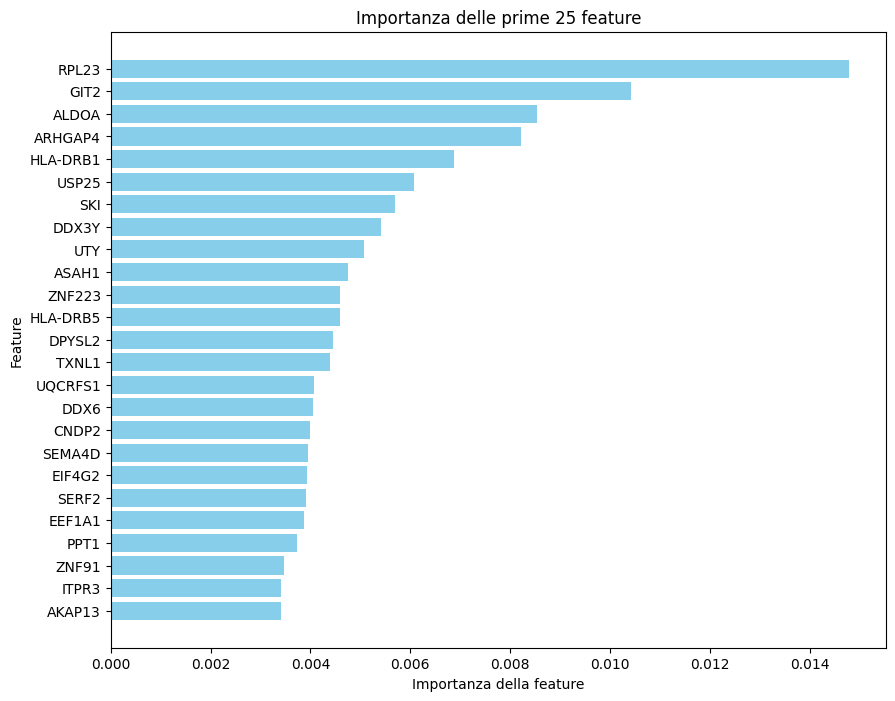

In [12]:
plt.figure(figsize=(10, 8))
plt.barh(list(expl_sorted.keys())[:25][::-1], list(expl_sorted.values())[:25][::-1], color='skyblue')
plt.xlabel('Importanza della feature')
plt.ylabel('Feature')
plt.title('Importanza delle prime 25 feature')
plt.show()

<h1>Ablation</h1>

In [7]:
def calcScores(x_test, y_test, model):
    scores = {col: 0 for col in x_test.columns}
    i = 1
    for exclude in range(x_train.shape[1]):
        x = x_test.copy()
        x[x.columns[exclude]] = x[x.columns[exclude]].mean()
        scores[x.columns[exclude]] = f1_score(y_test, model.predict(x))
        print(i)
        i += 1
    return scores

scores = calcScores(x_test, y_test, ensembleSelected)
joblib.dump(scores, '../../ShapValues/DatasetFull/ensembleSelected_ablationScoresPURI.pkl')

original = f1_score(y_test, ensembleSelected.predict(x_test))
new_scores = {key: original/value for key, value in scores.items()}
joblib.dump(new_scores, '../../ShapValues/DatasetFull/ensembleSelected_ablationScores.pkl')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


['../../ShapValues/DatasetFull/ensembleSelected_ablationScores.pkl']

In [3]:
new_scores = joblib.load('../../ShapValues/DatasetFull/ensembleSelected_ablationScores.pkl')
sorted_scores = dict(sorted(new_scores.items(), key=lambda item: item[1], reverse=True))
bestFeatures = {key: value for key, value in sorted_scores.items() if value > 1.0}
worstFeatures = {key: value for key, value in sorted_scores.items() if value < 1.0}
print("Le feature migliori sono: ", len(bestFeatures), bestFeatures)
print("Le feature rumorose sono: ", len(worstFeatures), worstFeatures)

print(list(bestFeatures.keys()))

Le feature migliori sono:  101 {'GIT2': 1.0063871238214235, 'TPM1': 1.0041666666666667, 'HLA-DRB5': 1.0039292730844793, 'TSPAN32': 1.0039292730844793, 'HLA-DRB1': 1.0024249697906304, 'RPL23': 1.0021938441388343, 'EEF1A1': 1.0021938441388343, 'EIF4G2': 1.0021938441388343, 'PPM1A': 1.0021938441388343, 'PAK2': 1.0021938441388343, 'MXI1': 1.0021938441388343, 'TXNRD1': 1.0021938441388343, 'MYL4': 1.0021938441388343, 'ZBTB5': 1.0021938441388343, 'THADA': 1.0021938441388343, 'CHMP6': 1.0021938441388343, 'CDKN2D': 1.0021938441388343, 'PLK3': 1.0021938441388343, 'CD6': 1.0021938441388343, 'ZNF606': 1.0021938441388343, 'MTRF1L': 1.0021938441388343, 'LILRA5': 1.0021938441388343, 'IRAK3': 1.0021938441388343, 'MYBL2': 1.0021938441388343, 'ETAA1': 1.0021938441388343, 'ARHGAP25': 1.0021938441388343, 'UBB': 1.0021938441388343, 'SSH1': 1.0021938441388343, 'SUCLG2': 1.0021938441388343, 'WDR1': 1.0021938441388343, 'GTPBP2': 1.0021938441388343, 'ICOSLG': 1.0021938441388343, 'MSH3': 1.0021938441388343, 'RP

<h1>Matrici di correlazione</h1>

Correlazione tra migliori 100 geni per shap values sulla matrice di importanze

In [15]:
ensembleCorr = pd.DataFrame(shap_values, columns=x_train.columns)[list(expl_sorted.keys())[:100]].corr()
print(ensembleCorr)

             RPL23      GIT2     ALDOA   ARHGAP4  HLA-DRB1     USP25  \
RPL23     1.000000  0.249089  0.142550  0.326449  0.139571  0.350631   
GIT2      0.249089  1.000000  0.236405  0.179978  0.089906  0.127083   
ALDOA     0.142550  0.236405  1.000000  0.354192  0.268573  0.190113   
ARHGAP4   0.326449  0.179978  0.354192  1.000000  0.177015  0.300300   
HLA-DRB1  0.139571  0.089906  0.268573  0.177015  1.000000  0.025253   
...            ...       ...       ...       ...       ...       ...   
PCBD1     0.158359  0.211961 -0.025056  0.079782  0.031002 -0.006885   
CD59      0.018010 -0.120854  0.074090 -0.074828 -0.193360  0.182901   
TXNRD1    0.147021  0.131501  0.046822 -0.023525 -0.082700  0.244969   
CSF1R     0.141250  0.148105  0.266976  0.233417  0.009880  0.174644   
ZBTB11   -0.027074  0.055081  0.353268  0.106559  0.084329  0.098726   

               SKI     DDX3Y       UTY     ASAH1  ...       GAK   ARHGEF2  \
RPL23     0.324229  0.461514  0.341755  0.256953  ...  0.0

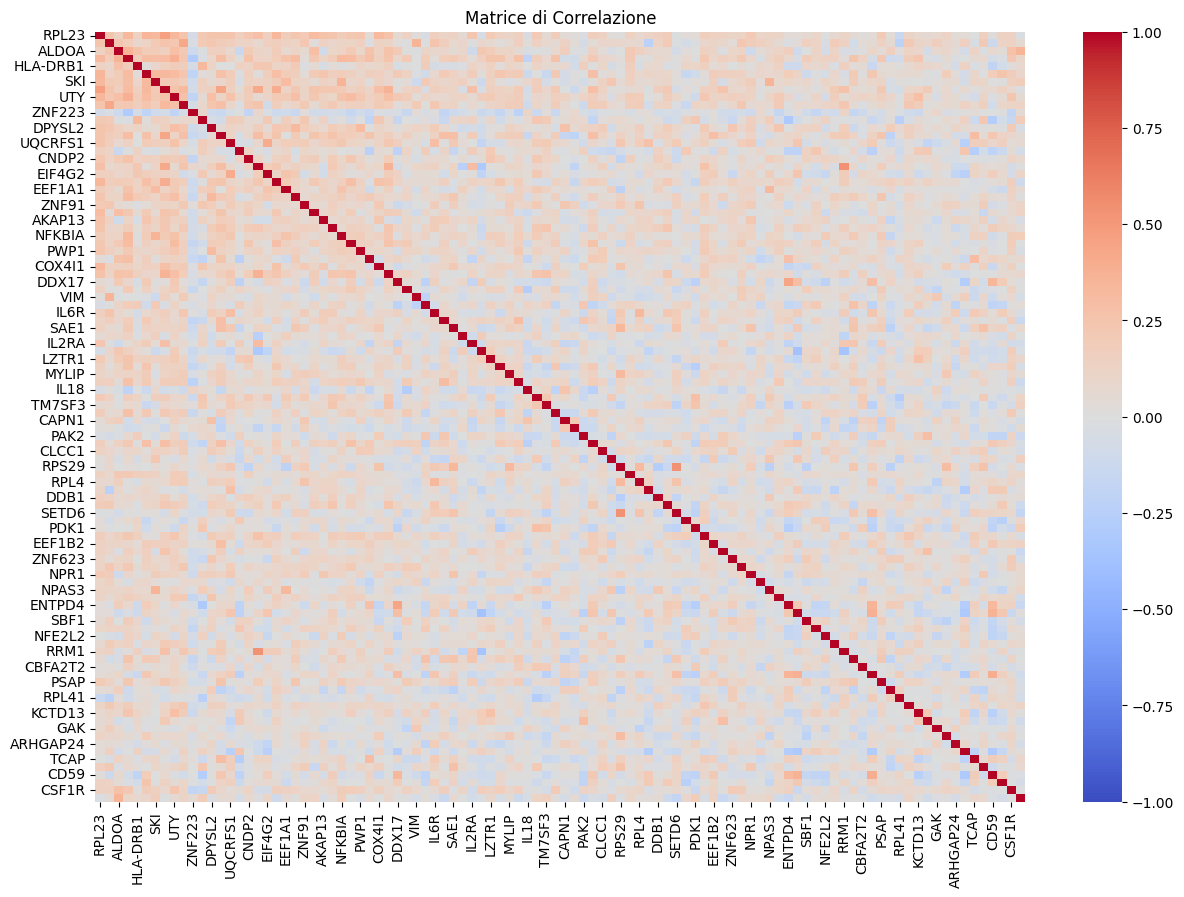

In [15]:
plt.figure(figsize=(15,10))
sns.heatmap(ensembleCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

In [21]:
ensemble_correlated_pairs = np.where(np.abs(ensembleCorr) >= 0.375)

# Print the correlated pairs
for i, j in zip(ensemble_correlated_pairs[0], ensemble_correlated_pairs[1]):
    if i != j:
        print(f"{ensembleCorr.index[i]} - {ensembleCorr.columns[j]}: {ensembleCorr.iloc[i, j]}")

retrieveGenes = []
for i, j in zip(ensemble_correlated_pairs[0], ensemble_correlated_pairs[1]):
    if i != j:
        if ensembleCorr.index[i] not in retrieveGenes:
            retrieveGenes.append(ensembleCorr.index[i])

print(retrieveGenes)

RPL23 - DDX3Y: 0.4615141903292873
GIT2 - ASAH1: 0.42345850781667976
ARHGAP4 - UTY: 0.3805099323965764
DDX3Y - RPL23: 0.4615141903292873
DDX3Y - TXNL1: 0.43893294891457507
DDX3Y - SEMA4D: 0.41517778446643827
DDX3Y - SERF2: 0.3979101892552422
UTY - ARHGAP4: 0.3805099323965764
ASAH1 - GIT2: 0.42345850781667976
TXNL1 - DDX3Y: 0.43893294891457507
UQCRFS1 - EIF4G2: 0.4035546365154341
SEMA4D - DDX3Y: 0.41517778446643827
SEMA4D - RRM1: 0.5380473079036756
EIF4G2 - UQCRFS1: 0.4035546365154341
SERF2 - DDX3Y: 0.3979101892552422
DDX17 - ENTPD4: 0.44487399970657093
RPS29 - SETD6: 0.5332292158681974
SETD6 - RPS29: 0.5332292158681974
ENTPD4 - DDX17: 0.44487399970657093
SERPINB9 - DNMT1: 0.3766478726473754
RRM1 - SEMA4D: 0.5380473079036756
DNMT1 - SERPINB9: 0.3766478726473754
DNMT1 - CD59: 0.396958300803723
CD59 - DNMT1: 0.396958300803723
['RPL23', 'GIT2', 'ARHGAP4', 'DDX3Y', 'UTY', 'ASAH1', 'TXNL1', 'UQCRFS1', 'SEMA4D', 'EIF4G2', 'SERF2', 'DDX17', 'RPS29', 'SETD6', 'ENTPD4', 'SERPINB9', 'RRM1', 'DNMT1

Correlazione tra intersezione migliori shap e ablation

{'SERPINB9', 'RPL41', 'HLA-DRB5', 'HBD', 'EEF1A1', 'HEXIM1', 'PRKAR2A', 'EIF4G2', 'TXNRD1', 'TCF3', 'AQP9', 'CHMP6', 'HLA-DRB1', 'PDK1', 'DDX17', 'WRNIP1', 'DDX3Y', 'PAK2', 'GIT2', 'RPL23'}


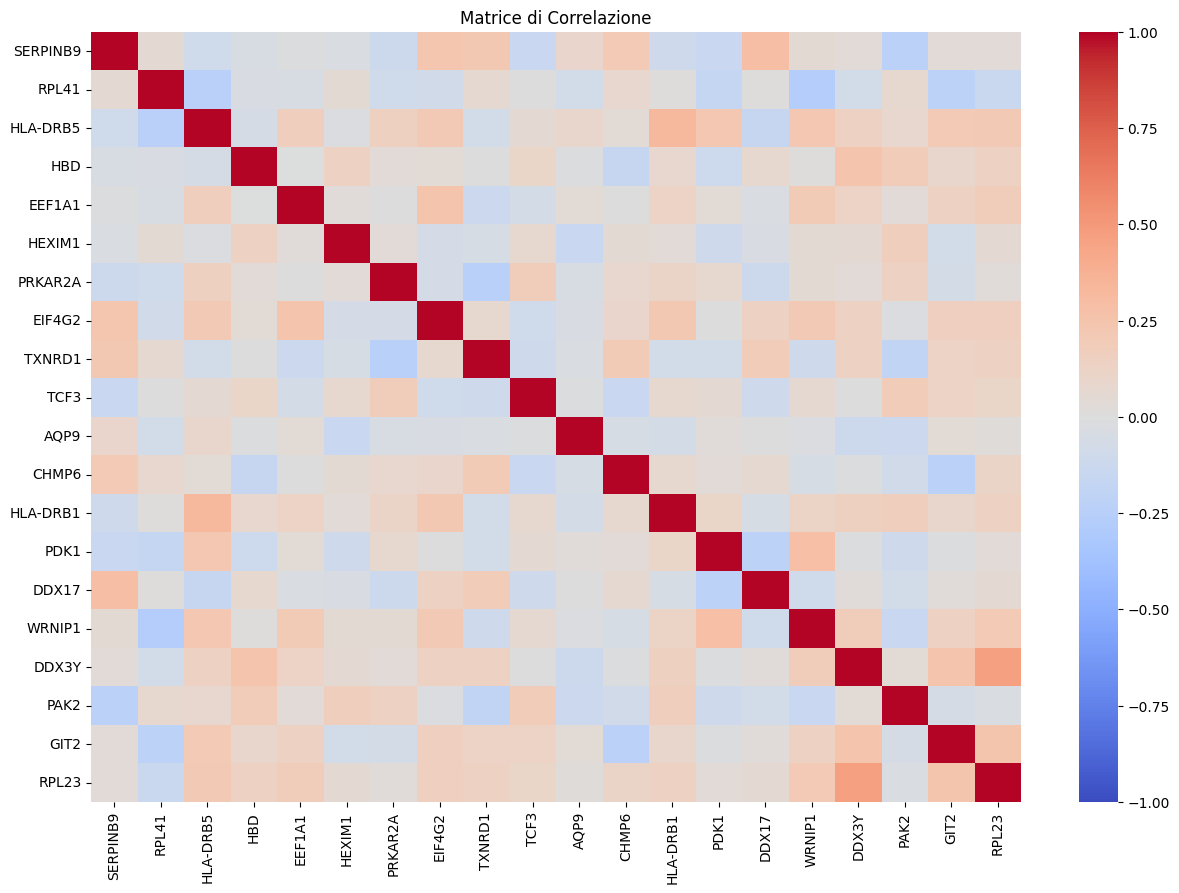

In [4]:
intersect = set(list(expl_sorted.keys())[:100]) & set(bestFeatures.keys())

print(intersect)

intersectCorr = pd.DataFrame(shap_values, columns=x_train.columns)[list(intersect)].corr()

plt.figure(figsize=(15,10))
sns.heatmap(intersectCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

In [18]:
intersect_correlated_pairs = np.where(np.abs(intersectCorr) >= 0.35)

# Print the correlated pairs
for i, j in zip(intersect_correlated_pairs[0], intersect_correlated_pairs[1]):
    if i != j:
        print(f"{intersectCorr.index[i]} - {intersectCorr.columns[j]}: {intersectCorr.iloc[i, j]}")

DDX3Y - RPL23: 0.46151419032928737
RPL23 - DDX3Y: 0.46151419032928737


<h1>Biogrid graph</h1>

In [5]:
os.chdir("../../scriptPython/DatasetFull")

def load_files_to_dataframes(directory, geneList, file_extension='.txt'):
    dataframes = {}
    
    for name in geneList:
        print(name)
        filename = name+'.tab3.txt'
        if filename in os.listdir(directory):
            print("File presente, caricamento in corso...")
            if filename.endswith(file_extension):
                file_path = os.path.join(directory, filename)
        else:
            print("File non presente")
            scrape.main(name)

        df = pd.read_csv(file_path, delimiter='\t')[['Official Symbol Interactor A', 'Official Symbol Interactor B']]
        df['Interaction'] = df.apply(
        lambda row: '_'.join(sorted([row['Official Symbol Interactor A'], row['Official Symbol Interactor B']])), axis=1)
        dataframes[filename] = df

    return dataframes

Grafo con i migliori 100 ottenuti da shapValues

In [ ]:
geneList = list(expl_sorted.keys())[:100]
dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []

i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)
concatenated_df.drop_duplicates(inplace=True)

# Crea un grafo non orientato
G = nx.Graph()

for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    if gene_a in geneList and gene_b in geneList:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G)  # Posizioni dei nodi per il layout
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='black')
plt.title('Interazioni tra geni - BioGRID')
plt.show()

Grafo con i migliori geni ablation

In [ ]:
geneList = list(bestFeatures.keys())
dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []

i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)
concatenated_df.drop_duplicates(inplace=True)

# Crea un grafo non orientato
G = nx.Graph()

for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    if gene_a in geneList and gene_b in geneList and gene_a != gene_b:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)  # Posizioni dei nodi per il layout
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='black')
plt.title('Interazioni tra geni - BioGRID')
plt.show()

Grafo con intersezione tra i migliori 50 shapValues e i migliori ablation

In [4]:
goodIntersect = set(list(expl_sorted.keys())[:50]).intersection(set(list(bestFeatures.keys())))
evilIntersect = set(list(expl_sorted.keys())[:50]).intersection(set(list(worstFeatures.keys())))
                                                                
print(goodIntersect)
print(evilIntersect)

{'RPL23', 'EEF1A1', 'HLA-DRB1', 'WRNIP1', 'EIF4G2', 'DDX3Y', 'DDX17', 'GIT2', 'HLA-DRB5'}
{'IFI6', 'ALDOA', 'RNASET2', 'ITPR3', 'ASAH1', 'SKI', 'ATF7IP', 'IL6R', 'PHF2', 'PPT1', 'USP25', 'AKAP13', 'SMARCA4'}


TXNRD1
File presente, caricamento in corso...
CHMP6
File presente, caricamento in corso...
PRKAR2A
File presente, caricamento in corso...
HBD
File presente, caricamento in corso...
HLA-DRB5
File presente, caricamento in corso...
WRNIP1
File presente, caricamento in corso...
DDX17
File presente, caricamento in corso...
HEXIM1
File presente, caricamento in corso...
GIT2
File presente, caricamento in corso...
TCF3
File presente, caricamento in corso...
HLA-DRB1
File presente, caricamento in corso...
PAK2
File presente, caricamento in corso...
DDX3Y
File presente, caricamento in corso...
EEF1A1
File presente, caricamento in corso...
RPL41
File presente, caricamento in corso...
PDK1
File presente, caricamento in corso...
SERPINB9
File presente, caricamento in corso...
RPL23
File presente, caricamento in corso...
AQP9
File presente, caricamento in corso...
EIF4G2
File presente, caricamento in corso...


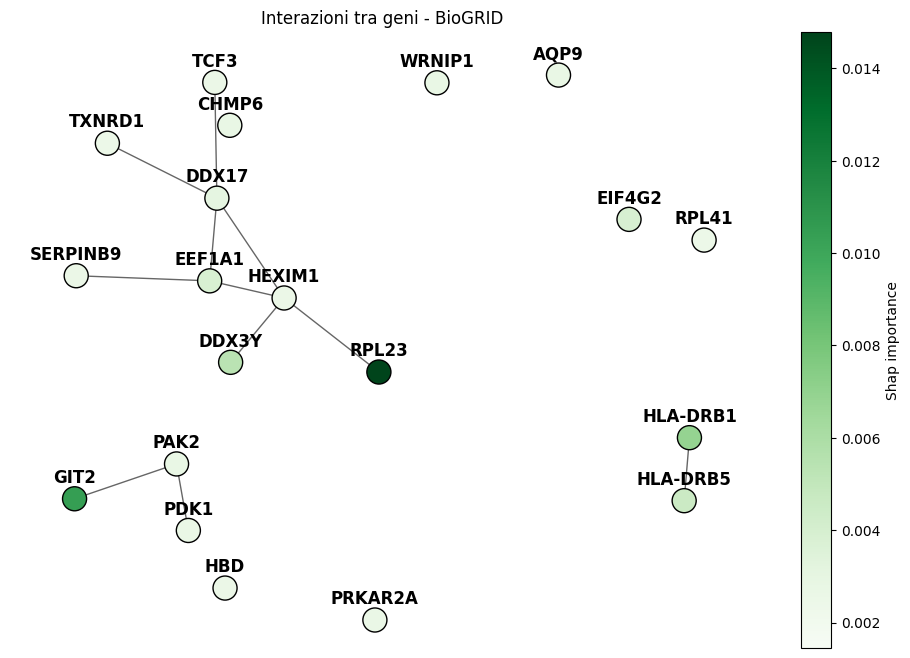

In [149]:
geneList = list(goodIntersect)
dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []


i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)
concatenated_df.drop_duplicates(inplace=True)

# Crea un grafo non orientato
G = nx.Graph()

for node in geneList:
    G.add_node(node)

for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    if gene_a in geneList and gene_b in geneList:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.6)
fig, ax = plt.subplots(figsize=(12,8))

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - BioGRID')
plt.axis('off')
plt.show()

Grafo con intersezione tra i migliori 100 per importance ed i migliori ablation

In [5]:
goodIntersect = set(list(expl_sorted.keys())[:100]).intersection(set(list(bestFeatures.keys())))
evilIntersect = set(list(expl_sorted.keys())[:100]).intersection(set(list(worstFeatures.keys())))
                                                                
print(goodIntersect)
print(evilIntersect)

{'RPL23', 'EEF1A1', 'TCF3', 'PAK2', 'HLA-DRB5', 'PRKAR2A', 'RPL41', 'TXNRD1', 'HLA-DRB1', 'DDX17', 'SERPINB9', 'CHMP6', 'HBD', 'PDK1', 'DDX3Y', 'EIF4G2', 'HEXIM1', 'WRNIP1', 'AQP9', 'GIT2'}
{'IFI6', 'ALDOA', 'RNASET2', 'ITPR3', 'PPT1', 'USP25', 'AKAP13', 'RPL4', 'ASAH1', 'ZNF623', 'SMARCA4', 'SBF1', 'SKI', 'ATF7IP', 'NPR1', 'NPAS3', 'IL6R', 'PHF2', 'ENTPD4'}


PAK2
File presente, caricamento in corso...
RPL41
File presente, caricamento in corso...
HLA-DRB1
File presente, caricamento in corso...
DDX3Y
File presente, caricamento in corso...
HLA-DRB5
File presente, caricamento in corso...
WRNIP1
File presente, caricamento in corso...
AQP9
File presente, caricamento in corso...
SERPINB9
File presente, caricamento in corso...
DDX17
File presente, caricamento in corso...
TXNRD1
File presente, caricamento in corso...
PDK1
File presente, caricamento in corso...
EEF1A1
File presente, caricamento in corso...
CHMP6
File presente, caricamento in corso...
HBD
File presente, caricamento in corso...
GIT2
File presente, caricamento in corso...
EIF4G2
File presente, caricamento in corso...
PRKAR2A
File presente, caricamento in corso...
RPL23
File presente, caricamento in corso...
TCF3
File presente, caricamento in corso...
HEXIM1
File presente, caricamento in corso...


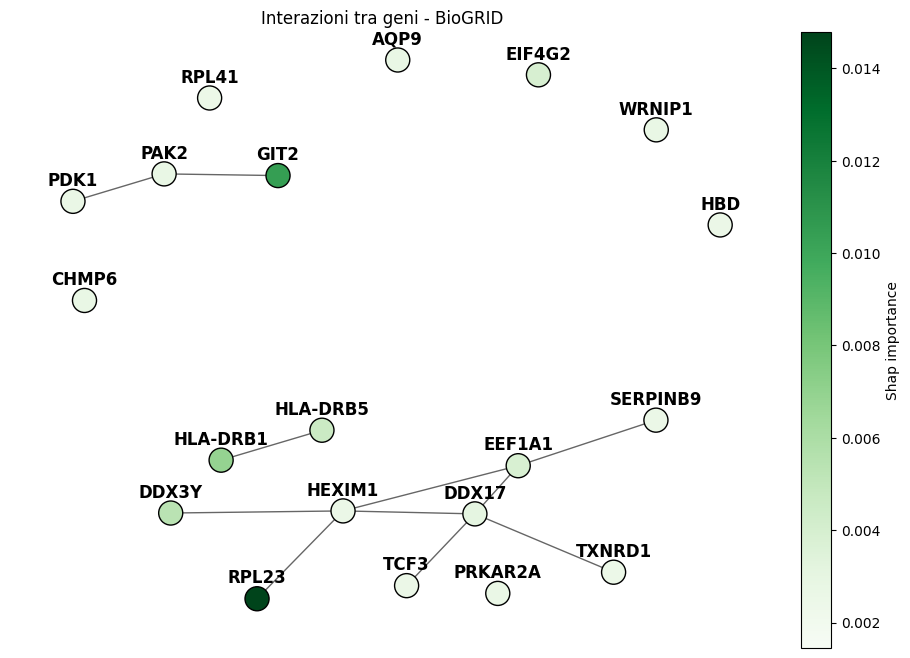

In [61]:
geneList = list(goodIntersect)
dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []


i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)
concatenated_df.drop_duplicates(inplace=True)

# Crea un grafo non orientato
G = nx.Graph()

for node in geneList:
    G.add_node(node)

for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    if gene_a in geneList and gene_b in geneList:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.6)
fig, ax = plt.subplots(figsize=(12,8))
# nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors, node_size=2500,
#                  font_color='black', edgecolors = 'black', font_weight='bold',font_size='9')

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - BioGRID')
plt.axis('off')
plt.show()

Grafo con interazioni matrice di correlazione migliori 100 shap importance

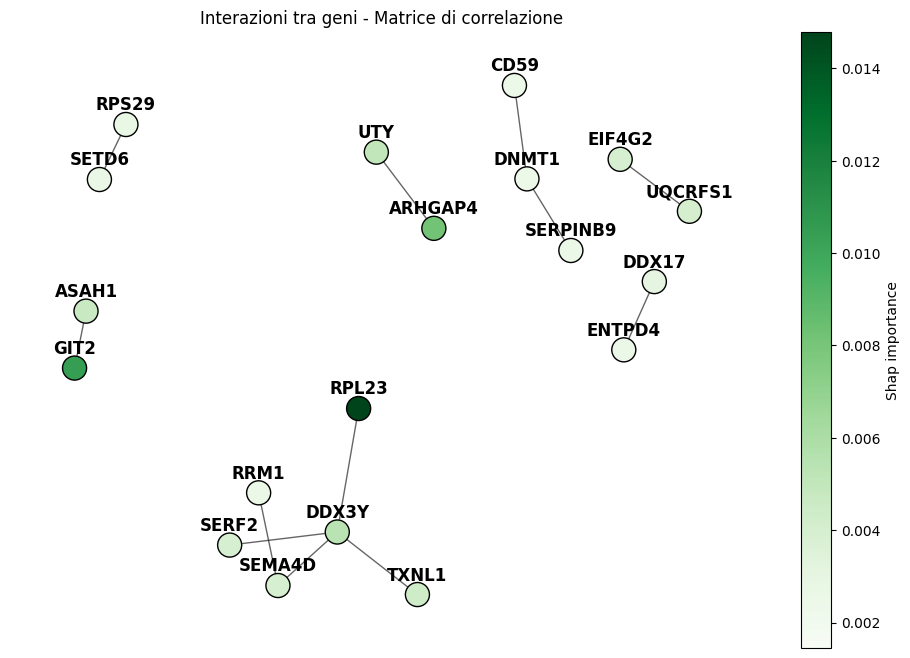

In [171]:
ensembleCorr = pd.DataFrame(shap_values, columns=x_train.columns)[list(expl_sorted.keys())[:100]].corr()

G = nx.Graph()

for i in range(ensembleCorr.shape[0]):
    for j in range(ensembleCorr.shape[1]):
        if abs(ensembleCorr.iloc[i, j]) > 0.375 and i != j:
            G.add_edge(ensembleCorr.columns[i], ensembleCorr.columns[j])

norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.6)
fig, ax = plt.subplots(figsize=(12,8))
# nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors, node_size=2500,
#                  font_color='black', edgecolors = 'black', font_weight='bold',font_size='9')

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - Matrice di correlazione')
plt.axis('off')
plt.show()

Grafo ottenuto da matrice di correlazione con intersezione migliori 100 geni e ablation

{'RPL23', 'EEF1A1', 'TCF3', 'PAK2', 'HLA-DRB5', 'PRKAR2A', 'RPL41', 'TXNRD1', 'HLA-DRB1', 'DDX17', 'SERPINB9', 'CHMP6', 'HBD', 'PDK1', 'DDX3Y', 'EIF4G2', 'HEXIM1', 'WRNIP1', 'AQP9', 'GIT2'}
             RPL23    EEF1A1      TCF3      PAK2  HLA-DRB5   PRKAR2A  \
RPL23     1.000000  0.172691  0.104041 -0.030290  0.212916  0.028805   
EEF1A1    0.172691  1.000000 -0.073772  0.035619  0.168285  0.001358   
TCF3      0.104041 -0.073772  1.000000  0.190479  0.054939  0.174002   
PAK2     -0.030290  0.035619  0.190479  1.000000  0.081826  0.147027   
HLA-DRB5  0.212916  0.168285  0.054939  0.081826  1.000000  0.151945   
PRKAR2A   0.028805  0.001358  0.174002  0.147027  0.151945  1.000000   
RPL41    -0.138239 -0.041035  0.001854  0.072334 -0.241247 -0.101031   
TXNRD1    0.147021 -0.128730 -0.108176 -0.191749 -0.082557 -0.243544   
HLA-DRB1  0.139571  0.125425  0.075442  0.168646  0.327915  0.114682   
DDX17     0.055191 -0.025391 -0.105615 -0.083790 -0.160314 -0.117249   
SERPINB9  0.037283

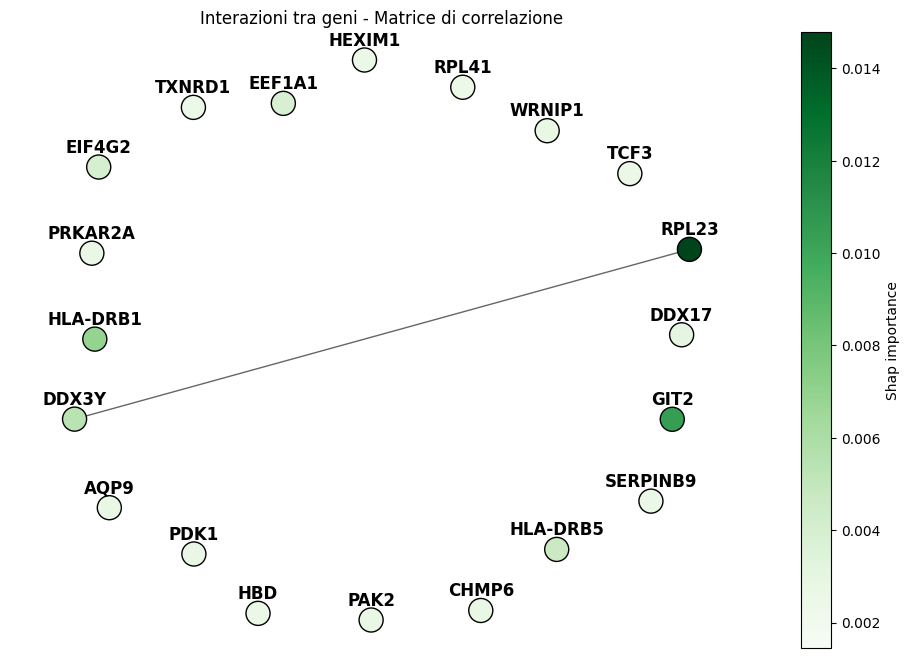

In [6]:
intersect = set(list(bestFeatures.keys())).intersection(set(list(expl_sorted.keys())[:100]))

print(intersect)

intersectCorr = pd.DataFrame(shap_values, columns=x_train.columns)[list(intersect)].corr()

print(intersectCorr)

G = nx.Graph()

for i in range(intersectCorr.shape[0]):
    G.add_node(intersectCorr.columns[i])
    for j in range(intersectCorr.shape[1]):
        if abs(intersectCorr.iloc[i, j]) > 0.375 and i != j:
            print(intersectCorr.columns[i], intersectCorr.columns[j])
            G.add_edge(intersectCorr.columns[i], intersectCorr.columns[j])

norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=3)
fig, ax = plt.subplots(figsize=(12,8))
# nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors, node_size=2500,
#                  font_color='black', edgecolors = 'black', font_weight='bold',font_size='9')

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - Matrice di correlazione')
plt.axis('off')
plt.show()

In [ ]:
#backuo del vecchio codice per fare i grafici di interazione
# Disegna il grafo
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G)  # Posizioni dei nodi per il layout
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='black')
plt.title('Interazioni tra geni - BioGRID')
plt.show()

#backup del nuovo codice per i grafi
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.6)
fig, ax = plt.subplots(figsize=(12,8))
# nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors, node_size=2500,
#                  font_color='black', edgecolors = 'black', font_weight='bold',font_size='9')

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - BioGRID')
plt.axis('off')
plt.show()